In [1]:
# https://jmetzen.github.io/2015-11-27/vae.html

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import pandas as pd
import os
import pickle
import socket
import matplotlib
#plt.style.use('seaborn-pastel')
plt.style.use(matplotlib.style.available[19])

np.random.seed(0)
tf.set_random_seed(0)

comp_name=socket.gethostname()
print('Computer: ' + comp_name)

if 'niao' in comp_name:
    gpus = [0]
    os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

Computer: niao


In [2]:
def xavier_init(fan_in, fan_out, constant=1):
    low = -constant*np.sqrt(6.0/(fan_in + fan_out))
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

In [3]:
class VariationalAutoencoder(object):
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                learning_rate=0.001, batch_size=100, latent_loss_factor=0.5):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.latent_loss_factor = latent_loss_factor
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # create the autoencoder network
        self._create_network()
        
        # define loss function based variational upper bound and optimizer
        self._create_loss_optimizer()
        
        # initialize the variables
        init = tf.global_variables_initializer()
        #init = tf.initialize_all_tables()
        
        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _create_network(self):
        # init the network weighs and biases
        network_weights = self._initialize_weights(**self.network_architecture)
        
        # use recognition network to deterimen mean and log variance of Gauss dist in latent space
        self.z_mean, self.z_log_sigma_sq = \
        self._recognition_network(network_weights["weights_recog"],
                                 network_weights["biases_recog"])
        
        # draw one sample z from gaussian
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 0.5, dtype=tf.float32)
        
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                       tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        
        # Use generator to determine mean of bernoulli distr of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                   network_weights["biases_gener"])
    
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2,
                           n_hidden_gener_1, n_hidden_gener_2,
                           n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))
        }
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        }
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))
        }
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))
        }
        return all_weights
    
    def _recognition_network(self, weights, biases):
        # generate probabilistic encoder to map inputs onto a normal distribution in latent space
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']),
                                          biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                          biases['b2']))
        
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                       biases['out_mean'])
        
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                               biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (maps points in latent space to 
        # bernoulli distri in data space
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),
                                          biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                          biases['b2']))
        
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']),
                                              biases['out_mean']))
        print(x_reconstr_mean.shape)
        return x_reconstr_mean
    
    def _create_loss_optimizer(self):
#         reconstr_loss = -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
#                                       + (1 - self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
#                                       1)
        
        reconstr_loss = tf.reduce_sum(tf.square(self.x - self.x_reconstr_mean))
        
        latent_loss = -self.latent_loss_factor * tf.reduce_sum(1 + self.z_log_sigma_sq
                                          - tf.square(self.z_mean)
                                          - tf.exp(self.z_log_sigma_sq), 1)
        
        self.cost = tf.reduce_mean(reconstr_loss +  0.*latent_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                 feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """Generate data by sampling from latent space."""
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
            
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, feed_dict={self.x: X})
    
    
def train_spec(network_architecture, learning_rate=0.001, batch_size=100,
         training_epochs=10, latent_loss_factor=0.5):
    
    vae = VariationalAutoencoder(network_architecture,
                                learning_rate=learning_rate,
                                batch_size=batch_size,
                                latent_loss_factor = latent_loss_factor)
    # Training cycle
    for epoch in tqdm(range(training_epochs), leave=True):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        for i in (range(total_batch)):
            batch_xs, _ = pdb.train_batch(batch_size)
            cost = vae.partial_fit(batch_xs)
            avg_cost += cost / n_samples * batch_size
    return vae

In [4]:
# load the synthesis data
sweep_file = '/mnt/cube/earneodo/bci_zf/syn_sweeps/spectral_pandas_sweep_002.pickle'
import pickle
df_syn = pd.read_pickle(sweep_file)

### filter frequency bands

In [5]:
def filter_freq_band(df, f_min=300, f_max=7500):
    f_list = np.array(df_syn.iloc[0].freq)
    f_sel = np.where((f_list > f_min) & (f_list < f_max))[0]
    f_filt = f_list[f_sel]
    
    all_spec_arr = np.array(df['spectral'].tolist())
    df['spectral'] = all_spec_arr[:, f_sel].tolist()
    return f_filt, df

f_list, filt_df = filter_freq_band(df_syn)

In [6]:
all_spectra_array = np.array(df_syn['spectral'].tolist())
#plt.plot(all_spectra[1]);
all_spectra_array.shape

(160000, 61)

In [7]:
from swissknife.bci import synthetic as syn

In [8]:
# a batch generator using pandas

def normalize(u):
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    return (u + u_min)/u_range

class PdBatcher(object):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.9):
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        self._make_test_array()
        
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.test_frame = self.data_frame[random_frac:]
        self.train_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = np.concatenate([np.array(s) for s in all_spectra], axis=1)/self.max_pow
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
    def _make_test_array(self):
        all_spectra = np.array(self.test_frame['spectral'].as_matrix())
        self.all_test_array = np.stack([np.array(s)[:,:300] for s in all_spectra], axis=0)/self.max_pow
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [self.all_train_array[:, idx].T, self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = self.all_test_array[idx]
        return test_array_batch
    
# a batch generator using pandas
class SynBatcher(PdBatcher):
    def __init__(self, data_frame, x_field=None, y_field=None, train_factor=0.9):
    
        PdBatcher.__init__(self, data_frame, 
              x_field=x_field, y_field=y_field, train_fraction=train_factor)
       
    def _make_train_array(self):
        all_spectra = (np.array(self.train_frame['spectral'].as_matrix()))
        self.all_train_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.train_label_array = np.array([self.train_frame['a'], self.train_frame['b']]).T
        
    def _make_test_array(self):
        all_spectra = (np.array(self.test_frame['spectral'].as_matrix()))
        self.all_test_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.test_label_array = np.array([self.test_frame['a'], self.test_frame['b']]).T

    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[0], n).tolist()
        return [(self.all_train_array[idx]), self.train_label_array[idx]]
    
    def test_batch(self, n):
        idx = np.random.randint(0, self.all_test_array.shape[0], n).tolist()
        return [(self.all_test_array[idx]), self.test_label_array[idx]]

#pdb = PdBatcher(df.loc[df['bird'].isin(['z007', 'z020', 'z017'])])
pdb = SynBatcher(df_syn)
print(df_syn.shape)
b_size = 100
x, y = pdb.train_batch(b_size)
n_samples = pdb.all_train_array.shape[0]

(160000, 6)


In [9]:
x, y = pdb.test_batch(b_size)

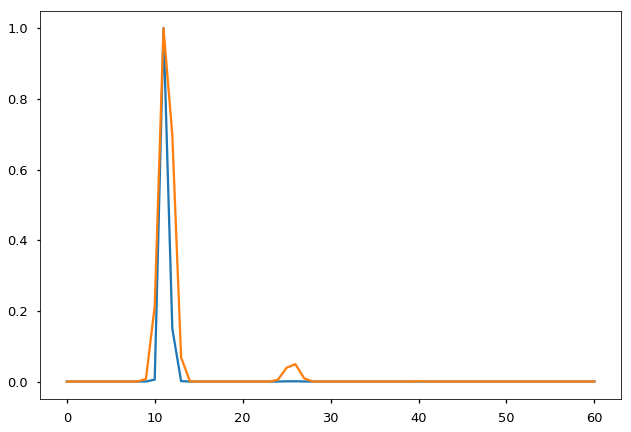

In [14]:
plt.plot(syn.np_mulog_inv(x[50]))
plt.plot((x[50]))

In [15]:
all_spectra = np.array(pdb.train_frame['spectral'].as_matrix())
pdb.all_train_array[[1,5]].shape

(2, 61)

In [16]:
b_size = 100
x, y = pdb.train_batch(b_size)
n_samples = pdb.all_train_array.shape[0]

In [17]:
pdb.all_test_array.shape[1]

61

In [18]:
network_architecture = \
    dict(n_hidden_recog_1=70, # 1st layer encoder neurons
         n_hidden_recog_2=30, # 2nd layer encoder neurons
         n_hidden_gener_1=30, # 1st layer decoder neurons
         n_hidden_gener_2=70, # 2nd layer decoder neurons
         n_input=pdb.all_test_array.shape[1], # 
         n_z=20)  # dimensionality of latent space



vae = train_spec(network_architecture, training_epochs=20, 
                 batch_size=b_size, 
                 latent_loss_factor=0.3)

(100, 61)


100%|██████████| 20/20 [01:04<00:00,  3.21s/it]


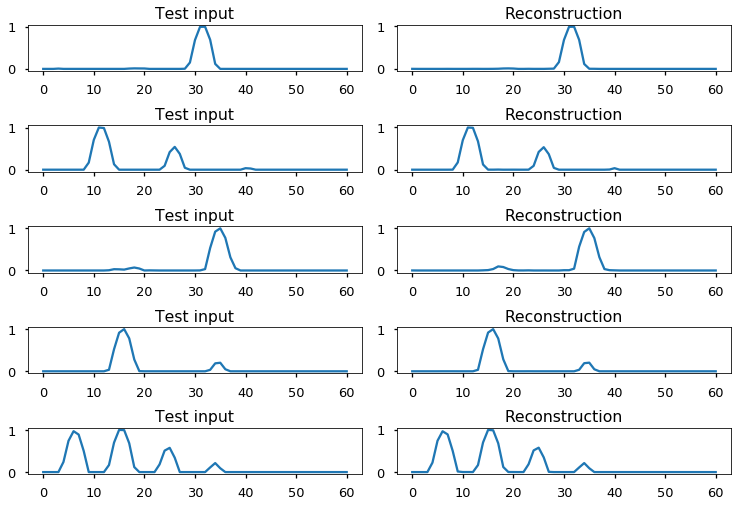

In [15]:
x_sample = pdb.train_batch(b_size)[0]
x_reconstruct = vae.reconstruct(x_sample)

for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()

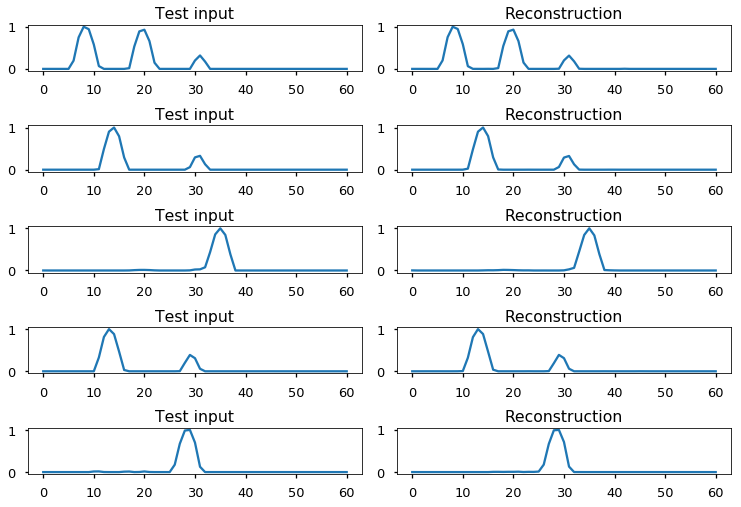

In [16]:
x_sample = pdb.test_batch(b_size)[0]
x_reconstruct = vae.reconstruct(x_sample)

for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()

In [19]:
# a batch generator using pandas
birds_sessions = {'z020': ['day-2016-06-02', 'day-2016-06-03', 'day-2016-06-04', 'day-2016-06-05', 'day-2016-06-06'],
                 'z017': ['day-2016-06-17', 'day-2016-06-18', 'day-2016-06-19', 'day-2016-06-20', 'day-2016-06-21', 
                          'day-2016-06-22', 'day-2016-06-23', 'day-2016-06-24', 'day-2016-06-27', 'day-2016-06-28'],
                  'z007': ['day-2016-09-07', 'day-2016-09-09', 'day-2016-09-10', 'day-2016-09-11', 'day-2016-09-12', 
                           'day-2016-09-13', 'day-2016-09-14']
                 }

all_df = []

for bird, sess_list in birds_sessions.items():
    if bird=='z007':
        for sess in sess_list:
            data_file = os.path.join('/mnt/cube/earneodo/bci_zf/ss_data/', bird, sess, 'spectral_pandas.pickle')
            all_df.append(pd.read_pickle(data_file))

        
df = pd.concat(all_df)


In [20]:
# a batch generator using pandas
birds_sessions = {'z020': ['day-2016-06-02', 'day-2016-06-03', 'day-2016-06-04', 'day-2016-06-05', 'day-2016-06-06'],
                 'z017': ['day-2016-06-17', 'day-2016-06-18', 'day-2016-06-19', 'day-2016-06-20', 'day-2016-06-21', 
                          'day-2016-06-22', 'day-2016-06-23', 'day-2016-06-24', 'day-2016-06-27', 'day-2016-06-28'],
                  'z007': ['day-2016-09-07', 'day-2016-09-09', 'day-2016-09-10', 'day-2016-09-11', 'day-2016-09-12', 
                           'day-2016-09-13', 'day-2016-09-14']
                 }

all_df = []

for bird, sess_list in birds_sessions.items():
    if bird=='z007':
        for sess in sess_list:
            data_file = os.path.join('/mnt/cube/earneodo/bci_zf/ss_data/', bird, sess, 'spectral_pandas.pickle')
            all_df.append(pd.read_pickle(data_file))

        
df = pd.concat(all_df)

bird_f_list, bird_df = filter_freq_band(df)

class PdBatcher(object):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.9):
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        self._make_test_array()
        
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.data_frame.fillna(0)
        self.test_frame = self.data_frame[random_frac:]
        self.train_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = np.concatenate([np.array(s) for s in all_spectra], axis=1)/self.max_pow
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
        no_silence = np.where(np.nansum(self.all_train_array, axis=0)>0)[0]
        self.all_train_array = self.all_train_array[:, no_silence]
        self.all_label_array = self.all_label_array[no_silence]


        
    def _make_test_array(self):
        all_spectra = np.array(self.test_frame['spectral'].as_matrix())
        self.all_test_array = np.stack([np.array(s)[:,:593] for s in all_spectra], axis=0)/self.max_pow
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [syn.np_mulog(self.all_train_array[:, idx].T), self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = syn.np_mulog(self.all_test_array[idx])
        return test_array_batch

pd_bird = PdBatcher(df[df.sess=='day-2016-09-10'])
print(df.shape)
x, y = pd_bird.train_batch(b_size)
n_samples = pd_bird.all_train_array.shape[-1]

(306, 6)


In [21]:
df[df.sess=='day-2016-09-10']

,bird,freq,rec,sess,spectral,start
0,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",0,day-2016-09-10,"[[66.80002887533377, 84.85003512230168, 147.27...",1163019
1,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",0,day-2016-09-10,"[[57.40423244052596, 57.40423244052596, 71.385...",1089649
2,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",0,day-2016-09-10,"[[106.49270939231606, 59.127014762152335, 59.1...",1066718
3,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",0,day-2016-09-10,"[[93.04789881411988, 93.04789881411988, 93.047...",1140048
4,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",0,day-2016-09-10,"[[142.6942765009097, 169.83793304266368, 61.91...",1044059
5,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",1,day-2016-09-10,"[[113.44303294484341, 113.44303294484341, 113....",800016
6,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",1,day-2016-09-10,"[[94.80395209885202, 94.80395209885202, 94.803...",776742
7,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",1,day-2016-09-10,"[[93.03648950914067, 93.03648950914067, 93.036...",1071350
8,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",1,day-2016-09-10,"[[107.30188582232348, 173.33581435419038, 93.1...",863317
9,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",1,day-2016-09-10,"[[81.28955831663974, 81.28955831663974, 81.289...",839863


In [22]:
all_df[0].head()

,bird,freq,rec,sess,spectral,start
0,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",6,day-2016-09-07,"[[9.6450142279619, 19.470635812715123, 34.8639...",7895887
1,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",6,day-2016-09-07,"[[69.38056524068718, 56.55295224090765, 53.362...",7946538
2,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",6,day-2016-09-07,"[[77.59296731951792, 88.89776529139766, 54.267...",7946531
3,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",7,day-2016-09-07,"[[18.240290966105253, 51.72828725991976, 82.26...",825505
4,z007,"[0.0, 117.1875, 234.375, 351.5625, 468.75, 585...",7,day-2016-09-07,"[[1.9299405800828227, 2.559623420281853, 2.179...",849868


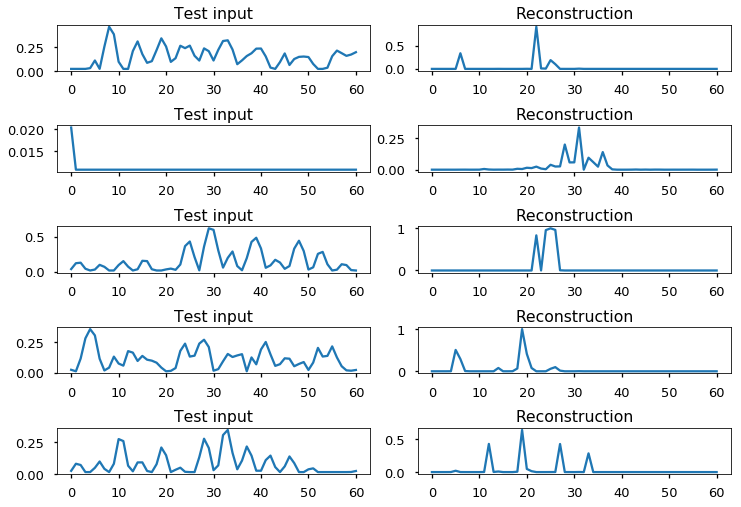

In [23]:
x_sample = pd_bird.train_batch(b_size)[0]
x_reconstruct = vae.reconstruct(x_sample)
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()

In [28]:
x_test = pd_bird.test_batch(2)
x_test.shape

(2, 61, 589)

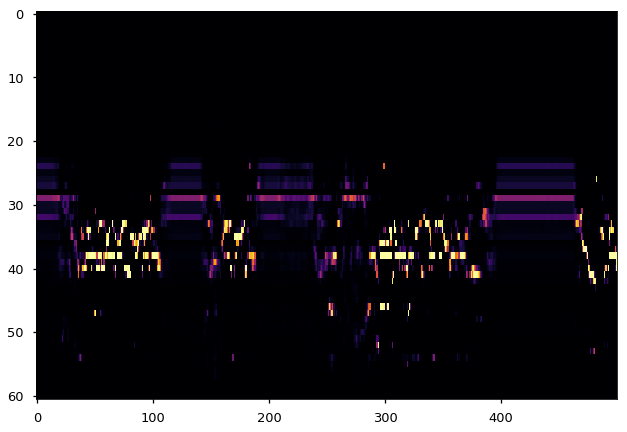

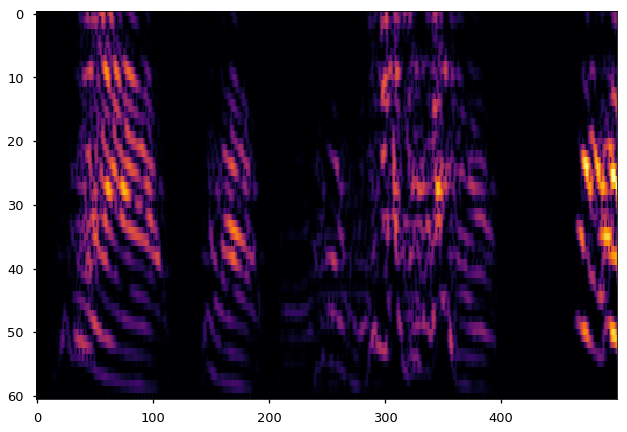

In [24]:
def motiff_reconstruct(n_motiff):
    x_test = pd_bird.test_batch(n_motiff)
    x_reconstruct = []
    for i in range(n_motiff):
        x_i= []
        for j in range(x_test.shape[-1]//b_size):
            x_i.append(vae.reconstruct(x_test[i, :, j*b_size:(j+1)*b_size].T))
        x_reconstruct.append(np.concatenate(x_i))
    return np.stack(x_reconstruct, axis=0), x_test

x_r, x_test = motiff_reconstruct(2)
x_r.shape

sample_view = 0
plt.imshow(x_r[sample_view].T[::-1], aspect='auto', cmap='inferno')
plt.figure()
plt.imshow(x_test[sample_view][:,:500][::-1], aspect='auto', cmap='inferno')

In [ ]:
x_test = pd_bird.train_batch(b_size)[0]
x_test[1].shape

In [ ]:
x_r[0].shape

In [ ]:
x_sample = pd_bird.train_batch(b_size)[0]
x_reconstruct = vae.reconstruct(x_sample)

for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()

In [ ]:
sample_view = 1
plt.imshow(x_r[sample_view].T[::-1], aspect='auto')
plt.figure()
plt.imshow(x_test[sample_view][::-1], aspect='auto')

In [ ]:
plt.imshow(x_test[:,:100][::-1], aspect='auto')